In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


In [10]:
df = pd.read_csv("results/daily_sleep_summary.csv")

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

print("✅ Data loaded successfully!")
print(df.head())


✅ Data loaded successfully!
        date  HKCategoryValueSleepAnalysisAsleepCore  \
0 2024-07-28                                     0.0   
1 2024-07-29                                     0.0   
2 2024-07-30                                     0.0   
3 2024-07-31                                     0.0   
4 2024-08-02                                     0.0   

   HKCategoryValueSleepAnalysisAsleepDeep  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   HKCategoryValueSleepAnalysisAsleepREM  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   HKCategoryValueSleepAnalysisAsleepUnspecified  \
0                                      12.80000

In [11]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if not numeric_cols:
    raise ValueError("No numeric columns found in the dataset!")

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


In [12]:
iso = IsolationForest(contamination=0.1, random_state=42)
df["anomaly"] = iso.fit_predict(df[numeric_cols])
df["is_anomaly"] = df["anomaly"] == -1

print(f"🚨 Detected {df['is_anomaly'].sum()} anomalies out of {len(df)} total days.")


🚨 Detected 8 anomalies out of 78 total days.


/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


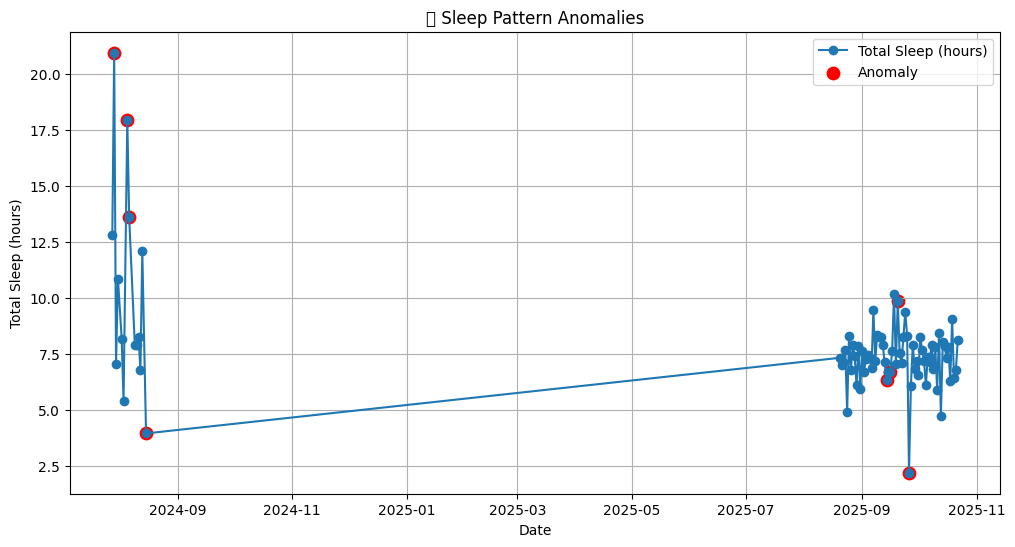

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["total_sleep_hours"], label="Total Sleep (hours)", marker='o')
plt.scatter(
    df.loc[df["is_anomaly"], "date"],
    df.loc[df["is_anomaly"], "total_sleep_hours"],
    color="red", label="Anomaly", s=80
)
plt.title("🧠 Sleep Pattern Anomalies")
plt.xlabel("Date")
plt.ylabel("Total Sleep (hours)")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
anomalies = df.loc[df["is_anomaly"], ["date", "total_sleep_hours"] + [c for c in numeric_cols if c != "total_sleep_hours"]]

sample_data = anomalies.head(10).to_markdown(index=False)

prompt = f"""
You are a sleep scientist analyzing daily sleep data anomalies.

Below is a sample of detected unusual days in the user's sleep metrics:

{sample_data}

Explain:
- What kind of irregularities are visible (short/long sleep, heart rate spikes, etc.)
- Possible causes (stress, exercise change, inconsistent bedtime)
- Actionable suggestions to restore healthy sleep patterns

Keep it analytical yet easy to understand.
"""


In [15]:
response = client.responses.create(
    model=os.getenv("GPT_MODEL"),
    input=prompt,
    temperature=0.7,
)

print("🧠 Fine-Tuned AI Anomaly Analysis:\n")
print(response.output[0].content[0].text)


🧠 Fine-Tuned AI Anomaly Analysis:

Irregularities Analysis:

- You seem to be experiencing a mix of short and long sleep durations.
- Variation in REM and deep sleep is noticeable.
- Sudden decrease in total sleep hours on specific dates.

Possible Causes:

- Your bedtime routine may be inconsistent.
- Increased stress levels could be impacting your sleep.
- Changes in physical activity or evening screen time might be affecting sleep quality.

Actionable Suggestions:

- Establish a consistent bedtime and bedtime routine.
- Incorporate relaxation techniques before bed to manage stress.
- Monitor and adjust evening activities that may be disrupting your sleep.

Monitor trends and adjust your routine accordingly.


In [16]:
import pandas as pd

daily_sleep = pd.read_csv("results/daily_sleep_summary.csv")
sleep_df = pd.read_csv("results/sleep_df.csv")

daily_sleep["date"] = pd.to_datetime(daily_sleep["date"])
sleep_df["date"] = pd.to_datetime(sleep_df["date"])

merged_df = pd.merge(daily_sleep, sleep_df, on="date", how="inner")

if "total_sleep_hours" not in merged_df.columns:
    if "duration" in merged_df.columns:
        merged_df["total_sleep_hours"] = merged_df["duration"] / 60  # assuming duration is in minutes
    else:
        merged_df["total_sleep_hours"] = merged_df.get("sleep_duration", 0)

if "is_anomaly" not in merged_df.columns:
    merged_df["is_anomaly"] = False

print("✅ merged_df ready:", merged_df.shape)
print(merged_df.head())


✅ merged_df ready: (1583, 13)
        date  HKCategoryValueSleepAnalysisAsleepCore  \
0 2024-07-28                                     0.0   
1 2024-07-28                                     0.0   
2 2024-07-29                                     0.0   
3 2024-07-29                                     0.0   
4 2024-07-29                                     0.0   

   HKCategoryValueSleepAnalysisAsleepDeep  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   HKCategoryValueSleepAnalysisAsleepREM  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   HKCategoryValueSleepAnalysisAsleepUnspecified  \
0                                          12

In [17]:
report_text = f"""
# 💤 Daily Sleep Insight Report
**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M')}

---

## 🧠 Fine-Tuned AI Analysis
{response.output[0].content[0].text.strip()}

---

## 📊 Anomaly Summary
- Total Days Analyzed: {len(merged_df)}
- Anomalous Days: {merged_df['is_anomaly'].sum()}

Chart: `{chart_path}`

---

## 💡 Key Takeaway
Consistent sleep and balanced exercise patterns reduce anomalies and improve recovery.
"""

report_path = f"results/reports/sleep_report_{datetime.now().strftime('%Y%m%d_%H%M')}.md"
with open(report_path, "w") as f:
    f.write(report_text)

print(f"✅ Report saved: {report_path}")


✅ Report saved: results/reports/sleep_report_20251103_1529.md


In [18]:
from IPython.display import Markdown, display

display(Markdown(report_text))


# 💤 Daily Sleep Insight Report
**Generated:** 2025-11-03 15:29

---

## 🧠 Fine-Tuned AI Analysis
Irregularities Analysis:

- You seem to be experiencing a mix of short and long sleep durations.
- Variation in REM and deep sleep is noticeable.
- Sudden decrease in total sleep hours on specific dates.

Possible Causes:

- Your bedtime routine may be inconsistent.
- Increased stress levels could be impacting your sleep.
- Changes in physical activity or evening screen time might be affecting sleep quality.

Actionable Suggestions:

- Establish a consistent bedtime and bedtime routine.
- Incorporate relaxation techniques before bed to manage stress.
- Monitor and adjust evening activities that may be disrupting your sleep.

Monitor trends and adjust your routine accordingly.

---

## 📊 Anomaly Summary
- Total Days Analyzed: 1583
- Anomalous Days: 0

Chart: `results/reports/anomalies_20251103_1527.png`

---

## 💡 Key Takeaway
Consistent sleep and balanced exercise patterns reduce anomalies and improve recovery.
